hi

In [1]:
# data and plotting
from torchctrnn.data.simulations import OrnsteinUhlenbeckData
from torchctrnn.data.utils import LongitudinalDataFrame,LongitudinalDataset,collate_fn_padd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

# deep learning
import torch
import torch.nn as nn
from torchctrnn import ODERNNCell,ODELSTMCell,NeuralODE

In [2]:
sim = OrnsteinUhlenbeckData(seed=1234)
df = sim.simulate(100)
df = df.loc[df.obs,:]
df.drop(columns=['obs'],inplace=True)
df.head()

,t,y_t,id
0,0.0,-0.303200,0
21,2.1,-0.842619,0
40,4.0,-0.918144,0
60,6.0,-1.128975,0
78,7.8,-1.073397,0


In [3]:
ids = df.id.unique()
train_ids,test_ids = train_test_split(ids)
df_train = df.loc[df.id.isin(train_ids),:]
df_test = df.loc[df.id.isin(test_ids),:]
print("train size: {}".format(df_train.shape[0]))
print("test size: {}".format(df_test.shape[0]))

train size: 940
test size: 317


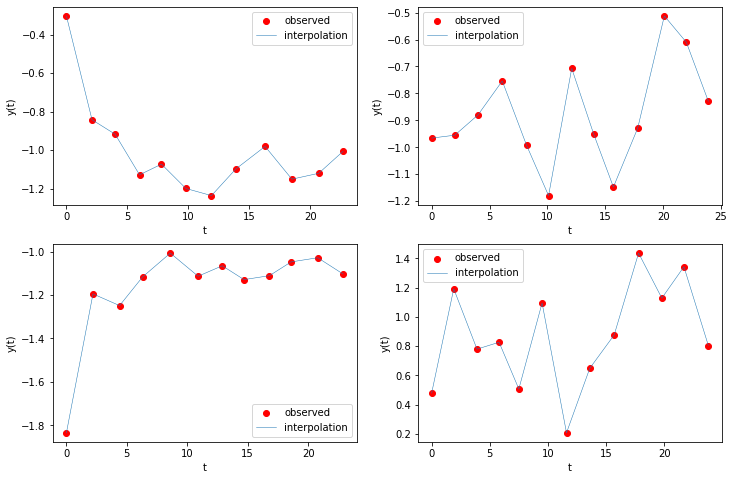

In [4]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (12,8))
_id = 0
for row in ax:
    for col in row:
        df_id = df.loc[(df.id == _id),:]
        col.scatter(df_id.t,df_id.y_t,label='observed',c='red')
        col.plot(df_id.t,df_id.y_t,linewidth=0.5,label='interpolation')
        col.set_xlabel('t')
        col.set_ylabel('y(t)')
        col.legend()
        _id += 1
plt.show()

Model

In [5]:
class ODERNNModel(nn.Module):
    """
    Full network
    """

    def __init__(self,ODENet,input_size,hidden_size,output_size):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.odernn = ODERNNCell(ODENet,input_size,hidden_size)
        self.decode = nn.Sequential(
            nn.Linear(hidden_size, 10),
            nn.Tanh(),
            nn.Linear(10, output_size),
        )

    def forward(self,times,x):
        """
        Forward method for the main model

        x = (batch,timestep,features)
        times = 
        """

        J = x.size(1)
        batch_size = x.size(0)
        output = torch.zeros(batch_size,J,self.output_size)
        h = torch.zeros(batch_size,self.hidden_size)
        for j in range(0,J):
            xj = x[:,j,:]
            times_j = times[:,j,:]
            h = self.odernn(xj,h,times_j)
            output[:,j,:] = self.decode(h)
        return output

In [6]:
x_size = 1  # number of input features
hidden_size = 4
output_size = 1

func = nn.Sequential(
            nn.Linear(hidden_size, 50),  # add one for time
            nn.Tanh(),
            nn.Linear(50, hidden_size)
        )
odenet = NeuralODE(func,time_func=lambda x : x / 24.0,time_dependent=False,data_dependent=False)
odernn = ODERNNModel(odenet,x_size,hidden_size,output_size)

optimizer = torch.optim.Adam(odernn.parameters())

In [7]:
train_dataset = LongitudinalDataset(df_train,'y_t','id','t')    
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, collate_fn=collate_fn_padd)

In [8]:
def train_model(model,optimizer,train_dataloader,criterion = nn.MSELoss(),num_epochs=10):
    for epoch in range(num_epochs):
        for batch in train_dataloader:
            x_batch,y_batch,t_batch = batch
            y_pred = model(t_batch,x_batch).squeeze(-1)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        print('Epoch: {}   Training loss: {}'.format(epoch, loss.item()))

In [9]:
train_model(odernn,optimizer,train_dataloader,num_epochs=5)

Epoch: 0   Training loss: 0.8333189487457275
Epoch: 1   Training loss: 0.8160097599029541
Epoch: 2   Training loss: 0.7999030351638794
Epoch: 3   Training loss: 0.7845771908760071
Epoch: 4   Training loss: 0.7695026397705078
Epoch: 5   Training loss: 0.7541391849517822
Epoch: 6   Training loss: 0.7380133867263794
Epoch: 7   Training loss: 0.720680832862854
Epoch: 8   Training loss: 0.7016950845718384
Epoch: 9   Training loss: 0.6806334257125854
Epoch: 10   Training loss: 0.6571547985076904
Epoch: 11   Training loss: 0.6310580372810364
Epoch: 12   Training loss: 0.602335512638092
Epoch: 13   Training loss: 0.5712234973907471
Epoch: 14   Training loss: 0.5382593870162964
Epoch: 15   Training loss: 0.5043219923973083
Epoch: 16   Training loss: 0.4706171452999115
Epoch: 17   Training loss: 0.4385640025138855
Epoch: 18   Training loss: 0.4095246493816376
Epoch: 19   Training loss: 0.38432684540748596
Epoch: 20   Training loss: 0.36274516582489014
Epoch: 21   Training loss: 0.343538045883178

In [10]:
ltest = LongitudinalDataFrame(df_test,'y_t','id','t')
ltest.time_shift_dataframe()
X_test,y_test,dt_test = ltest.split(to_torch=True)

In [11]:
test_dataset = LongitudinalDataset(df_test,'y_t','id','t') 

In [12]:
y_pred = []
with torch.no_grad():
    for i,data in enumerate(test_dataset):
        X_i,y_i,dt_i = data
        X_i = torch.tensor(X_i)
        dt_i = torch.tensor(dt_i)
        y_pred_i = odernn(dt_i.unsqueeze(0),X_i.unsqueeze(0)).squeeze(0)
        y_pred.append(y_pred_i.numpy())

In [13]:
y_pred = np.vstack(y_pred)

In [14]:
df_test = ltest.df

In [15]:
df_test['prediction'] = y_pred

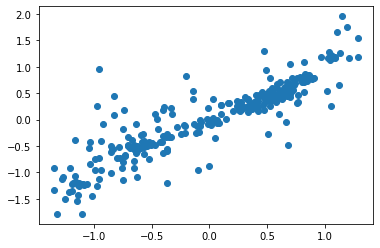

In [16]:
plt.scatter(df_test.prediction,df_test.target)

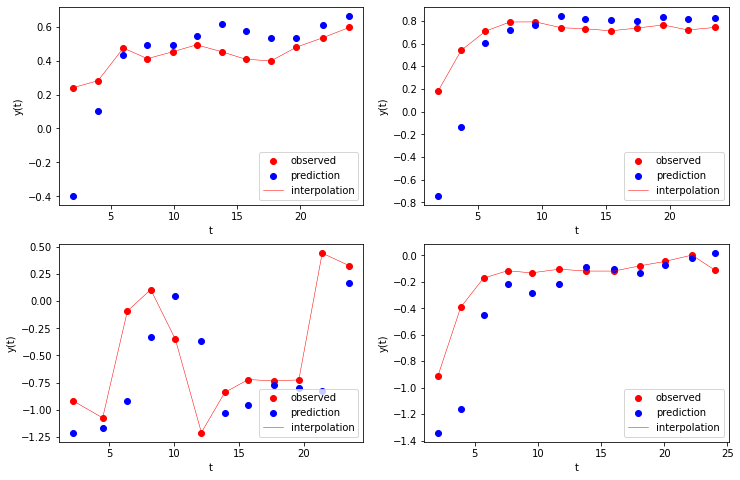

In [25]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (12,8))
ids = df_test.id.unique()[0:4]
i = 0
for row in ax:
    for col in row:
        df_id = df_test.loc[(df_test.id == ids[i]),:]
        col.scatter(df_id.t1,df_id.target,label='observed',c='red')
        col.scatter(df_id.t1,df_id.prediction,label='prediction',c='blue')
        col.plot(df_id.t1,df_id.target,linewidth=0.5,label='interpolation',c='red')
        col.set_xlabel('t')
        col.set_ylabel('y(t)')
        col.legend()
        i += 1
plt.show()